In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import scipy.signal as signal
from scipy import sparse
from scipy.sparse.linalg import spsolve

/home/apk/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
efile=['ME_2_AA2018.10.06_11.49.23.hdf5', 'ME_2_2018.10.08_11.23.55.hdf5','ME_2_2018.10.24_11.39.29.hdf5',
       'ME_2_2018.11.05_11.23.57.hdf5','ME_2_R_2019.01.04_12.46.47.hdf5']

In [3]:
for f in efile:
    eeg=h5py.File(f,mode='r')
    print f
    sampletime = np.array(eeg['AsynchronData']["Time"])
    
    sampletime1=np.delete(sampletime, len(sampletime)-1)
    sampletime1=np.delete(sampletime1, 0)
    print len(sampletime1)
    if len(sampletime)==1:
        sampletime1=sampletime
    if sampletime1[0]/256.0 <=4.0:
        print 'ooh'
        print sampletime1[0]/256.0
    #print (eeg['RawData']['Samples'].shape[0]-sampletime1[len(sampletime1)-1])/256.0
    if (eeg['RawData']['Samples'].shape[0]-sampletime1[len(sampletime1)-1])/256.0 <4.0:
        print 'noooo'
        print (eeg['RawData']['Samples'].shape[0]-sampletime1[len(sampletime1)-1])/256.0

ME_2_AA2018.10.06_11.49.23.hdf5
5
ooh
3.32421875
ME_2_2018.10.08_11.23.55.hdf5
5
ooh
3.94921875
ME_2_2018.10.24_11.39.29.hdf5
5
ooh
2.953125
ME_2_2018.11.05_11.23.57.hdf5
5
ooh
2.54296875
ME_2_R_2019.01.04_12.46.47.hdf5
5


In [4]:
def CAR(samples):
    s=[]
    for i in range(0, len(samples)):
        s.append((sum(samples))/64.0)
    
    sample=samples-s
    return sample, s

In [5]:
def elliptic_bandpass(order, rp, rs, lowcut, highcut):
    fs=256
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.ellip(order, rp, rs, [low, high], btype='bandpass', analog=False, output='ba')
    return b, a

In [6]:
spr_channels=[0,2,7,9,11,13,15,62,25,27,29,31,33,63,43,45,47,49,51,57,59]
spr_channel_names=['fp1','fp2','f7','f3','fz','f4','f8','A1','T3','C3','Cz','C4','T4','A2','T5','P3','Pz','P4','T6'
                  ,'O1','O2']

In [7]:
def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    #D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [8]:
plt.rcParams["figure.figsize"] = [25,16]

In [32]:
def ers_fig_5(efile, cnl_no):
    fig=plt.figure()
    c=0
    for f in efile:
        m=4.0
        n=4.0
        eeg=h5py.File(f,mode='r')
        sampletime = np.array(eeg['AsynchronData']["Time"])
        sampletime1=np.delete(sampletime, len(sampletime)-1)
        sampletime1=np.delete(sampletime1, 0)
       
        if (eeg['RawData']['Samples'].shape[0]-sampletime1[len(sampletime1)-1])/256.0 <4.0:
            sampletime1=np.delete(sampletime1, len(sampletime1)-1)
    
        if sampletime1[0]/256.0 <=4.0:
            sampletime1=np.delete(sampletime1, 0)
            
        #print sampletime1   
        samples=np.array(eeg['RawData']['Samples'])
        samples=samples.T
        samples, _=CAR(samples)##CAR of the samples
        
        
       
        
        beta=[]
        freq=[[0.5, 4], [4, 8], [8, 11], [15, 30], [30, 100]]
        fs=256
        order=4
        rp=0.5
        rs=30
        for i in range (0, len(samples)):
            b, a = elliptic_bandpass(order, rp, rs, freq[3][0], freq[3][1])
            beta.append(signal.filtfilt(b, a, samples[i], padlen=0))
            
        
        epoch_beta=[]
        
        for i in spr_channels:
            b=[]

            for j in sampletime1:
                b.append(beta[i][j-int(n)*256: j+int(m)*256])
           
            epoch_beta.append(b)
        
        ##Base line correction
        for i in range(0, len(epoch_beta[cnl_no])):
            #print len(epoch_beta[cnl_no][i])
            z= baseline_als(epoch_beta[cnl_no][i], 10**4, 0.01, 100)
            epoch_beta[cnl_no][i]=epoch_beta[cnl_no][i]-z
            
        ##  ERP=average of all trials(with size -4 to 4s)
        erp_beta=sum(epoch_beta[cnl_no])/len(epoch_beta[cnl_no])
        
        #subtract erp from all trials and square to get the power samples
        for i in range(0, len(epoch_beta[cnl_no])):
            epoch_beta[cnl_no][i]=epoch_beta[cnl_no][i]-erp_beta
            epoch_beta[cnl_no][i]=epoch_beta[cnl_no][i]**2
        
        #Average power samples to get ERS in beta    
        ers_beta=sum(epoch_beta[cnl_no])/len(epoch_beta[cnl_no])
        
        #Base line power is computed as average power in sampletime[0]to sampletime[1]
        base=beta[spr_channels[cnl_no]][int(sampletime[0]):int(sampletime[1])]
        z1=baseline_als(base, 10**4, 0.01, 10)
        base=base-z1
        basepower=np.mean(base**2)
        ers=(ers_beta-basepower)/basepower##ers as fraction of base power
        
        ##Using moving average filter to smooth the plot
        N=128
        mov=np.convolve(ers, np.ones((N,))/N, mode='valid')
        
        c=c+1
        plot=fig.add_subplot(3,3,c)
        plt.plot(np.arange(-len(mov)/512.0, len(mov)/512.0, 1/256.0), mov)
        plt.title('Day'+str(c))
        
    plt.tight_layout()
    plt.savefig(efile[0][:4]+'.png')

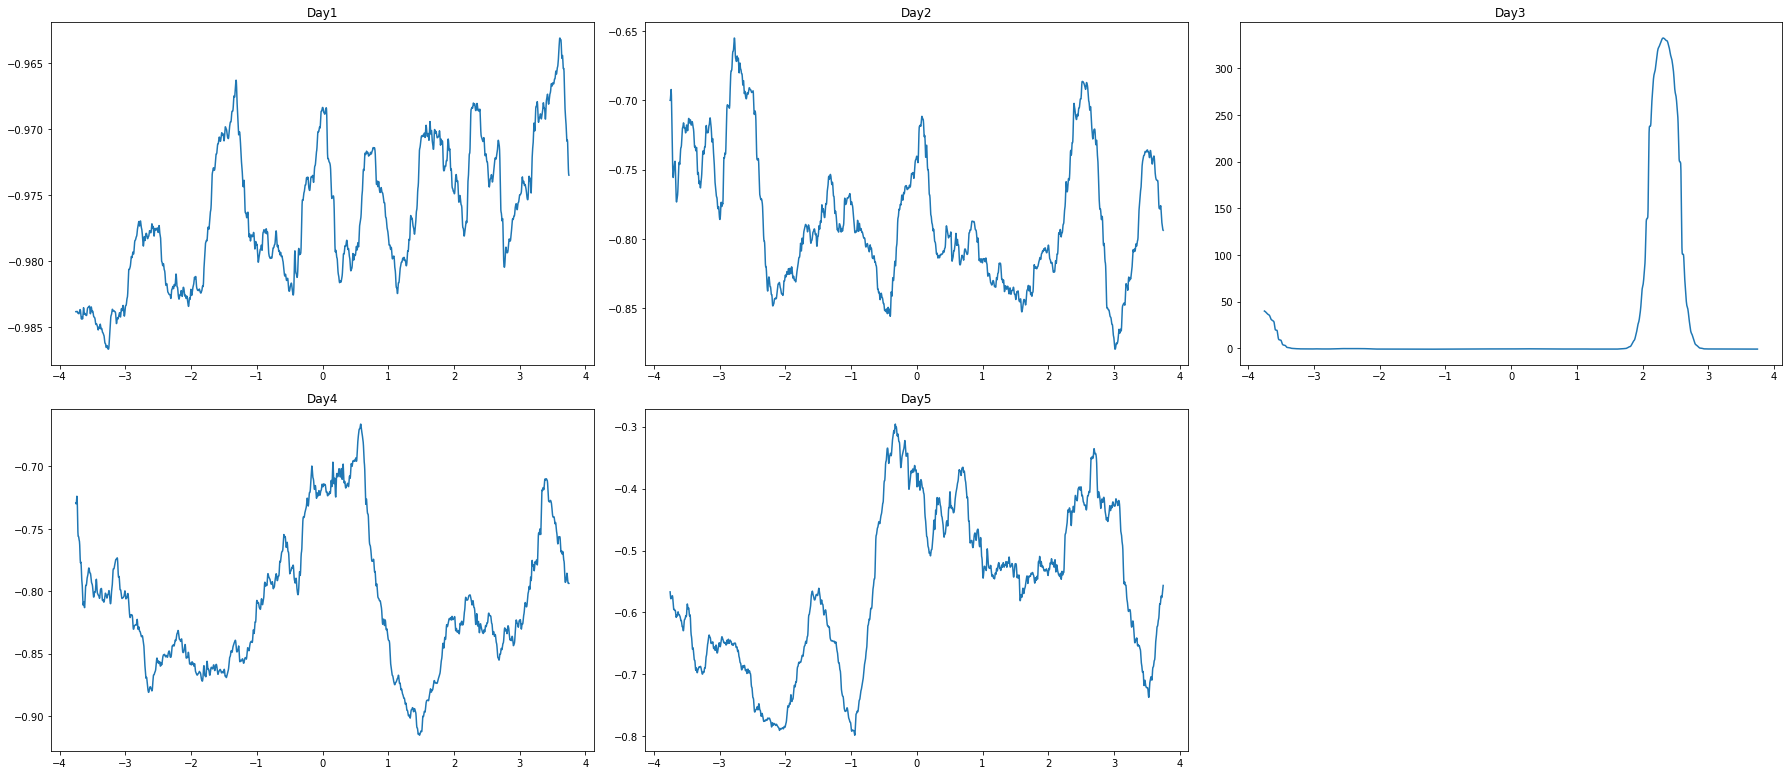

In [33]:
ers_fig_5(efile,9)

In [ ]:
for i in range(0, len(efile1)):
    for j in range (0, len(spr_channels)):
        ers_fig_5(efile1[i], j)

In [ ]:
def ers_fig_5(efile, cnl_no):
    fig=plt.figure()
    c=0
    for f in efile:
        m=4.0
        n=4.0
        eeg=h5py.File(f,mode='r')
        sampletime = np.array(eeg['AsynchronData']["Time"])
        sampletime1=np.delete(sampletime, len(sampletime)-1)
        sampletime1=np.delete(sampletime1, 0)
       
        if (eeg['RawData']['Samples'].shape[0]-sampletime1[len(sampletime1)-1])/256.0 <4.0:
            sampletime1=np.delete(sampletime1, len(sampletime1)-1)
    
        if sampletime1[0]/256.0 <=4.0:
            sampletime1=np.delete(sampletime1, 0)
            
        #print sampletime1   
        samples=np.array(eeg['RawData']['Samples'])
        samples=samples.T
        samples, _=CAR(samples)##CAR of the samples
        
        
       
        
        alpha=[]
        freq=[[0.5, 4], [4, 8], [8, 11], [15, 30], [30, 100]]
        fs=256
        order=4
        rp=0.5
        rs=30
        for i in range (0, len(samples)):
            b, a = elliptic_bandpass(order, rp, rs, freq[2][0], freq[2][1])
            alpha.append(signal.filtfilt(b, a, samples[i], padlen=0))
            
        
        epoch_alpha=[]
        
        for i in spr_channels:
            a=[]

            for j in sampletime1:
                a.append(alpha[i][j-int(n)*256: j+int(m)*256])
           
            epoch_alpha.append(a)
        
        ##Base line correction
        for i in range(0, len(epoch_alpha[cnl_no])):
            #print len(epoch_beta[cnl_no][i])
            z= baseline_als(epoch_alpha[cnl_no][i], 10**4, 0.01, 100)
            epoch_alpha[cnl_no][i]=epoch_alpha[cnl_no][i]-z
            
        ##  ERP=average of all trials(with size -4 to 4s)
        erp_alpha=sum(epoch_alpha[cnl_no])/len(epoch_alpha[cnl_no])
        
        #subtract erp from all trials and square to get the power samples
        for i in range(0, len(epoch_alpha[cnl_no])):
            epoch_alpha[cnl_no][i]=epoch_alpha[cnl_no][i]-erp_alpha
            epoch_alpha[cnl_no][i]=epoch_alpha[cnl_no][i]**2
        
        #Average power samples to get ERS in beta    
        erd_alpha=sum(epoch_alpha[cnl_no])/len(epoch_alpha[cnl_no])
        
        #Base line power is computed as average power in sampletime[0]to sampletime[1]
        base=alpha[spr_channels[cnl_no]][int(sampletime[0]):int(sampletime[1])]
        z1=baseline_als(base, 10**4, 0.01, 10)
        base=base-z1
        basepower=np.mean(base**2)
        erd=(erd_alpha-basepower)/basepower##ers as fraction of base power
        
        ##Using moving average filter to smooth the plot
        N=128
        mov=np.convolve(erd, np.ones((N,))/N, mode='valid')
        
        c=c+1
        plot=fig.add_subplot(3,3,c)
        plt.plot(np.arange(-len(mov)/512.0, len(mov)/512.0, 1/256.0), mov)
        plt.title('Day'+str(c))
        
    plt.tight_layout()
    plt.savefig(efile[0][:4]+'.png')